In [12]:
import keras as keras
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization
from keras.initializers import glorot_uniform
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Resizing, RandomCrop, RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import math
from IPython.display import Image
import math 

### Load data

In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ti = x_train[0]
print(ti.shape)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

def augmentattion(x_train, y_train, resizing) :
    
    model = Sequential([Rescaling(1/255.),
                        resizing,
                       RandomCrop(32,32), # 32 X 32로 조정되어 중심축이 변경되며 일부가 잘려진다.
                       RandomFlip('horizontal'),
                       RandomRotation(np.random.randint(0,360))])

    Model.build(model, (1, ti.shape[0], ti.shape[1], 3)) # 3차원
    
    globals()[f"x_train_2"] = model(x_train)
                
    # 데이터 결합
    globals()[f"x_train_all"] = np.concatenate((x_train, x_train_2), axis=0) 
    globals()[f"y_train_all"] = np.concatenate((y_train, y_train), axis=0)
    
    
    
resizing = Resizing(int(ti.shape[0]*1.1), int(ti.shape[1]*1.1)) 
augmentattion(x_train, y_train, resizing)

(32, 32, 3)
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


2022-12-07 14:11:15.378370: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9


### Resizing Data

In [17]:
num_classes = 10

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

X_train, y_train, X_test, y_test = load_cifar10_data(224, 224)

## model 설계

In [15]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

#### ResNet

In [23]:
def deepConv2D(x, fts, kns, std, name, num) :
    st = 1
    if std == 2 : st == 2
    else : st == 1
        
    y = Conv2D(filters=fts, kernel_size=kns, strides=std, padding='same', activation='relu', 
              kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    y = BatchNormalization()(y)
    
    for i in range(num-1) :
        y = Conv2D(filters=fts, kernel_size=kns, strides=1, padding='same', activation='relu', 
                  kernel_initializer=kernel_init, bias_initializer=bias_init)(y)
        y = BatchNormalization()(y)
    
    if std == 2 :
        x = Conv2D(filters=fts, kernel_size=1, strides=2, padding='same', activation='relu', 
                  kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
        x = BatchNormalization()(x)

      
    output = x + y
    return output    

#### googlenet

In [24]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', 
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


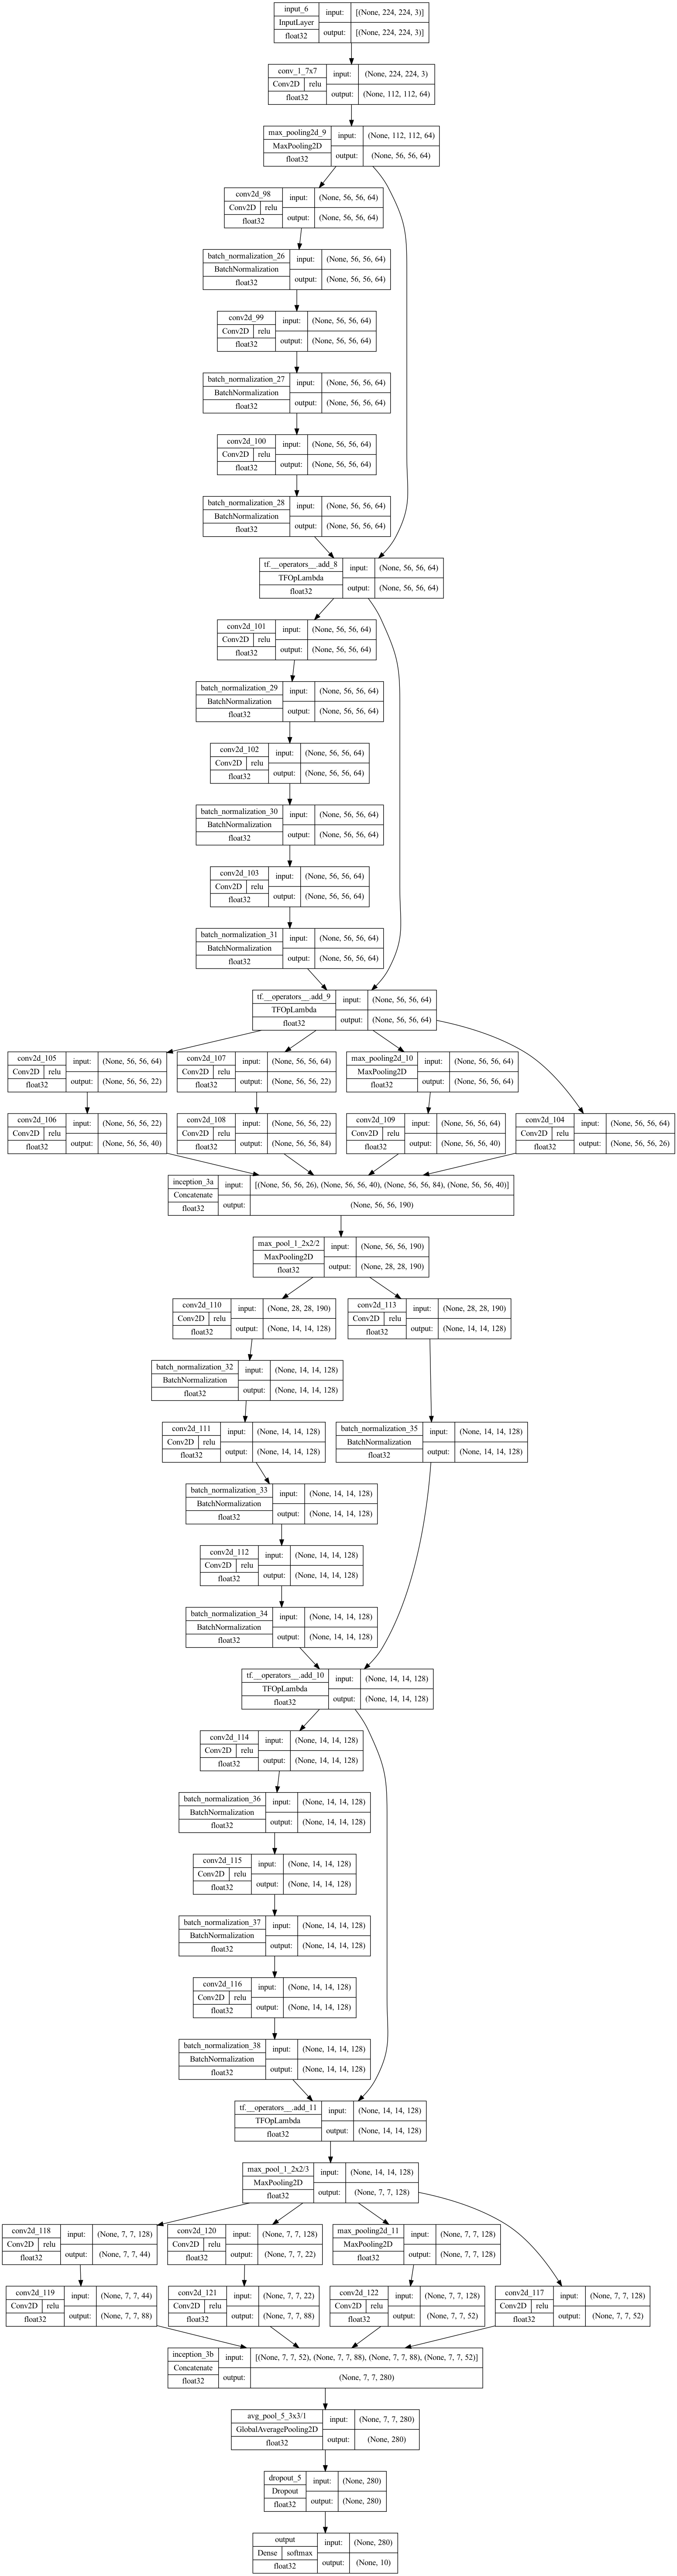

In [27]:
input_layer = Input(X_train.shape[1:])

# 
x = Conv2D(64, (7, 7), strides=(2,2), padding='same', activation='relu', name='conv_1_7x7', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2))(x)
x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/1", 3)
x = deepConv2D(x, 64, (3,3), 1, "Conv2D/64/3x3/2", 3)

x = inception_module(x,
                    filters_1x1 = 26,
                    filters_3x3_reduce = 22,
                    filters_3x3 = 40,
                    filters_5x5_reduce = 22,
                    filters_5x5 = 84,
                    filters_pool_proj = 40,
                    name="inception_3a")

x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_1_2x2/2')(x)

x = deepConv2D(x, 128, (3,3), 2, "Conv2D/128/3x3/1", 3)
x = deepConv2D(x, 128, (3,3), 1, "Conv2D/128/3x3/2", 3)

x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_1_2x2/3')(x)

x = inception_module(x,
                    filters_1x1 = 52,
                    filters_3x3_reduce = 44,
                    filters_3x3 = 88,
                    filters_5x5_reduce = 22,
                    filters_5x5 = 88,
                    filters_pool_proj = 52,
                    name="inception_3b")


x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
# x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

model1 = Model(input_layer, x, name='ResNet_JSR')

plot_model(model1, show_shapes=True, show_dtype=True, show_layer_activations=True)

## Model Fit & Evaluate

In [28]:
class MyCallback(Callback):
    def on_epoch_end(self, end, logs={}):
        if logs.get('val_acc') > 0.95:
            self.model.stop_training = True
            print('\n')
            print('목표 정확도 달성: 검증 정확도 %.4f' % logs.get('val_acc'))
my_callback = MyCallback()



def mdFit(model, num, X_train, y_train, my_callback) : # + best model select.

    model.compile(optimizer='adam',
              loss='categorical_crossentropy', #Not OneHot Encoding : sparse_categorical_crossentropy
              metrics=['acc'])
    model.summary()
       
    best_model_path = f"./bestModel/LeNet5/best_cnn_model{num}.h5" 
    save_best_model = ModelCheckpoint(best_model_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False)

    globals()[f'hist{num}'] = model.fit(
        x=X_train, y=y_train, batch_size=128, epochs=20, verbose=1,
        validation_split=0.2, callbacks=[my_callback ,save_best_model]) 
    # validation : (x_test, y_test)값을 가지고 와서 봐도 된다. 현재 0.2의 비율로 가져와서
    
    globals()[f'best_model{num}'] = load_model(best_model_path)
    globals()[f'best_model{num}'].summary()
    
    
def mdEval(model, x_tst, y_tst) :
    model.evaluate(x_tst, y_tst, batch_size=30, verbose=1)
    
def mdPred(model, X_tst) :
    result = model.predict(X_tst)
    return result

In [41]:
mdFit(model1, 0, X_train, y_train, my_callback)

Model: "ResNet_JSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7 (Conv2D)            (None, 112, 112, 64  9472        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv_1_7x7[0][0]']             
                                                                                         

                                                                                                  
 batch_normalization_35 (BatchN  (None, 14, 14, 128)  512        ['conv2d_113[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_34 (BatchN  (None, 14, 14, 128)  512        ['conv2d_112[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.add_10 (TFOpL  (None, 14, 14, 128)  0          ['batch_normalization_35[0][0]', 
 ambda)                                                           'batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_11

KeyboardInterrupt: 

In [32]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [39]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

    try:
        # 유효하지 않은 GPU 장치를 명시
        with tf.device('/device:GPU:2'):
            a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
            b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
            c = tf.matmul(a, b)
    except RuntimeError as e:
        print(e)

In [40]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)